# Visualize Single Task

We provide an example on how to read the logged data, stored in "application/backend/CollectedData/" for every participant and task. We further create a basic visualization of a single run. 

## Imports

In [3]:
import csv, sys, json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Exemplary Parameters

In [6]:
user = 1 #for first user
iteration = 0 #for first task

path = "application/backend/CollectedData" #specificy the base path to the "CollectedData" in the application


#NOTE: This input configuration points to the first participant, first task. Change the parameters to visualize different participants/tasks

## Visualizing Code

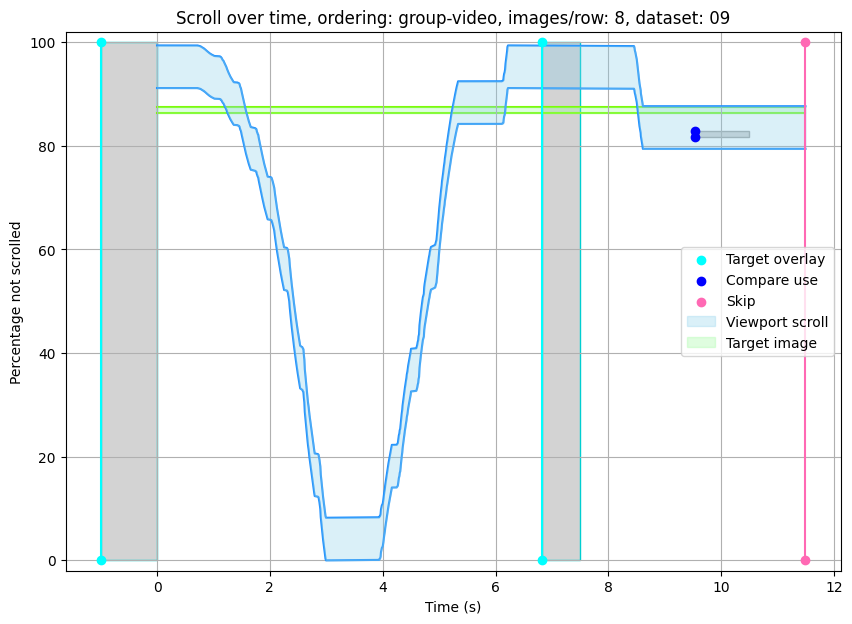

In [7]:
# returns reverse percentage of current height (scroll)
def normaliseHeight(currHeight, totalHeight):
    return (100 - 100*(currHeight / totalHeight))

# returns reverse percentage of current height (scroll)
def normaliseHeight(currHeight, totalHeight):
    return (100 - 100*(currHeight / totalHeight))

# load runs data
try:
    with open(f'{path}{user:04}/userData.json', "r") as json_file:
        json_data = json.load(json_file)
except FileNotFoundError:
    print("User not found!")
    exit()

# get data about target image
try:
    currentTarget = json_data[str(user)]["targets"][str(iteration)]
except KeyError:
    print("Iteration or player not found!")
    exit()

# define row separator size
ROW_SEPARATOR_SIZE = 33 # 10px margin on top and bottom, 10px grid spacing (but only 1 is added when row separator is added) and 3px line size = 10 + 10 + 10 + 3 = 33px

# get data about images
allGridItems = json_data[str(user)]["imagePos"][str(iteration)] # also contains row-separators
allImages = [item for item in allGridItems if item['image'] != "row-separator"]

targetPosition = next((index for index, item in enumerate(allImages) if item['image'] == currentTarget), None)   # find position of target in grid
imagesPerRow = int(json_data[str(user)]["imagesPerRow"][str(iteration)])

# handle missing target
rowSeparatorsBeforeTarget = 0
if targetPosition is None:
    targetRow = 0
    targetColors = ['lightcoral', 'mistyrose']   # red if target is missing
else:
    targetRow = targetPosition // imagesPerRow      # 4 or 8 images per row
    targetColors = ['lawngreen', 'palegreen']

    # Get the number of row separators before the clicked image (in group display)
    targetIndexInGrid = next((index for index, item in enumerate(allGridItems) if item['image'] == currentTarget), None)
    rowSeparatorsBeforeTarget = sum(1 for i in range(targetIndexInGrid) if allGridItems[i]['image'] == "row-separator")

# plot window size
fig, ax = plt.subplots(figsize=(10, 7))

# get scroll position data
timestamps = []
valuesTop = []
valuesBottom = []
targetTopLocations = []
targetBottomLocations = []

previousCompare = {"x" : 0, "y" : 0, "height" : 0}
previousTargetOverlay = {"x" : 0}
previousInstructionsOverlay = {"x" : 0}

afterLoadIndices = []

with open(f'{path}{user:04}/scrollPositions.txt', 'r') as file:
    

    reader = csv.reader(file, delimiter=';')
    for row in reader:
        if (int(row[0]) == user and int(row[1]) == iteration):
            timestamp = int(row[2])
            totalScroll = float(row[4])
            navbarHeight = float(row[7])
            windowHeight = float(row[6]) - navbarHeight     # account for navbar
            scrollValue = float(row[3]) + navbarHeight      # account for navbar

            # viewport position
            timestamps.append(timestamp)
            valuesTop.append(normaliseHeight(scrollValue, totalScroll))    # percentage not scrolled
            valuesBottom.append(normaliseHeight(scrollValue + windowHeight,  totalScroll))

            FirstRowHeight = float(row[8])
            SecondRowHeight = float(row[9])
            imageHeight = float(row[10])

            # get difference between rows to calculate position of target
            targetTopLocations.append(normaliseHeight(FirstRowHeight + targetRow * (SecondRowHeight - FirstRowHeight) + rowSeparatorsBeforeTarget * ROW_SEPARATOR_SIZE, totalScroll))
            targetBottomLocations.append(normaliseHeight(imageHeight + FirstRowHeight + targetRow * (SecondRowHeight - FirstRowHeight) + rowSeparatorsBeforeTarget * ROW_SEPARATOR_SIZE, totalScroll))

            afterLoad = int(row[12])
            if afterLoad == 1:
                afterLoadIndices.append(len(timestamps) - 1)
            

# get time to start from 0
minTime = min(timestamps)
normalisedTime = [((ts - minTime) / 1000) for ts in timestamps]

# draw red line to mark reloads
firstLoadLine = True
for afterLoadIndex in afterLoadIndices[1:]:
    lastTimestamp = normalisedTime[afterLoadIndex - 1]
    currentTimestamp = normalisedTime[afterLoadIndex]
    
    if(firstLoadLine):
        plt.axvline(x=lastTimestamp, color='red', linestyle='--', label='Unload/load')
        firstLoadLine = False
    else:
        plt.axvline(x=lastTimestamp, color='red', linestyle='--')
    plt.axvline(x=currentTimestamp, color='red', linestyle='--')


# to prevent multiple labels
firstIncorrect = True
firstCorrect = True
firstCompare = True
firstSkip = True
firstTargetOverlay = True
firstInstructionsOverlay = True

with open(f'{path}{user:04}/submissions.txt', 'r') as file:     # TODO: remove submission parameters
    reader = csv.reader(file, delimiter=';')
    for row in reader:
        if (int(row[0]) == user and int(row[1]) == iteration):
            subTimestamp = int(row[2])
            subTotalScroll = float(row[4])
            subNavbarHeight = float(row[5])
            subScroll = float(row[3]) + subNavbarHeight
            subWindowHeight = float(row[6]) - subNavbarHeight
            subFirstRow = float(row[7])
            subSecondRow = float(row[8])
            subImageHeight = float(row[9])
            subCorrect = int(row[10])
            subClickedImage = row[11]

            if subCorrect < 3:
                # get row of clicked image
                clickedImageRow = next((index for index, item in enumerate(allImages) if item['image'] == subClickedImage), None) // imagesPerRow

                # Get the number of row separators before the clicked image (in group display)
                clickedImageIndexInGrid = next((index for index, item in enumerate(allGridItems) if item['image'] == subClickedImage), None)
                rowSeparatorsBeforeClickedImage = sum(1 for i in range(clickedImageIndexInGrid) if allGridItems[i]['image'] == "row-separator")

                # calculate position of clicked image
                clickedImageLocation = subFirstRow + clickedImageRow * (subSecondRow - subFirstRow) + rowSeparatorsBeforeClickedImage * ROW_SEPARATOR_SIZE

            # display dot based on submission type, time and image position
            # incorrect
            if subCorrect == 0:
                # for label display
                if firstIncorrect:
                    plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(clickedImageLocation, subTotalScroll), color='red', zorder=3, label='Wrong guess')
                    firstIncorrect = False
                else:
                    plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(clickedImageLocation, subTotalScroll), color='red', zorder=3)

                plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(clickedImageLocation + subImageHeight, subTotalScroll), color='red', zorder=3)
                plt.plot([(subTimestamp - minTime) / 1000, (subTimestamp - minTime) / 1000], [normaliseHeight(clickedImageLocation, subTotalScroll), normaliseHeight(clickedImageLocation + subImageHeight, subTotalScroll)], color='red', zorder=3)

            # correct
            elif subCorrect == 1:
                # for label display
                if firstCorrect:
                    plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(clickedImageLocation, subTotalScroll), color='green', zorder=3, label='Correct guess')
                    firstCorrect = False
                else:
                    plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(clickedImageLocation, subTotalScroll), color='green', zorder=3)

                plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(clickedImageLocation + subImageHeight, subTotalScroll), color='green', zorder=3)
                plt.plot([(subTimestamp - minTime) / 1000, (subTimestamp - minTime) / 1000], [normaliseHeight(clickedImageLocation, subTotalScroll), normaliseHeight(clickedImageLocation + subImageHeight, subTotalScroll)], color='green', zorder=3)

            # compare
            elif subCorrect == 2:
                # for label display
                if firstCompare:
                    plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(clickedImageLocation, subTotalScroll), color='blue', zorder=3, label='Compare use')
                    firstCompare = False
                else:
                    plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(clickedImageLocation, subTotalScroll), color='blue', zorder=3)

                plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(clickedImageLocation + subImageHeight, subTotalScroll), color='blue', zorder=3)
                plt.plot([(subTimestamp - minTime) / 1000, (subTimestamp - minTime) / 1000], [normaliseHeight(clickedImageLocation, subTotalScroll), normaliseHeight(clickedImageLocation + subImageHeight, subTotalScroll)], color='blue', zorder=3)

                previousCompare['x'] = (subTimestamp - minTime) / 1000
                previousCompare['y'] = normaliseHeight(clickedImageLocation, subTotalScroll)
                previousCompare['height'] = normaliseHeight(clickedImageLocation + subImageHeight, subTotalScroll) - previousCompare['y']
            
            # compare end
            elif subCorrect == 3:
                rectWidth = ((subTimestamp - minTime) / 1000) - previousCompare['x']
                rectangle = patches.Rectangle((previousCompare['x'], previousCompare['y']), rectWidth, previousCompare['height'], linewidth=1, edgecolor='darkgray', facecolor='lightgray')
                ax.add_patch(rectangle)

            # skip
            elif subCorrect == 4:
                # for label display
                if firstSkip:
                    plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(0, subTotalScroll), color='hotpink', zorder=3, label='Skip')
                    firstSkip = False
                else:
                    plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(0, subTotalScroll), color='hotpink', zorder=3)

                plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(subTotalScroll, subTotalScroll), color='hotpink', zorder=3)
                plt.plot([(subTimestamp - minTime) / 1000, (subTimestamp - minTime) / 1000], [normaliseHeight(0, subTotalScroll), normaliseHeight(subTotalScroll, subTotalScroll)], color='hotpink', zorder=3)

            # target overlay
            elif subCorrect == 5:
                # for label display
                if firstTargetOverlay:
                    plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(0, subTotalScroll), color='cyan', zorder=3, label='Target overlay')
                    firstTargetOverlay = False
                else:
                    plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(0, subTotalScroll), color='cyan', zorder=3)

                plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(subTotalScroll, subTotalScroll), color='cyan', zorder=3)
                plt.plot([(subTimestamp - minTime) / 1000, (subTimestamp - minTime) / 1000], [normaliseHeight(0, subTotalScroll), normaliseHeight(subTotalScroll, subTotalScroll)], color='cyan', zorder=3)

                previousTargetOverlay['x'] = (subTimestamp - minTime) / 1000
            
            # target overlay end
            elif subCorrect == 6:
                rectWidth = ((subTimestamp - minTime) / 1000) - previousTargetOverlay['x']
                rectangle = patches.Rectangle((previousTargetOverlay['x'], normaliseHeight(0, subTotalScroll)), rectWidth, normaliseHeight(subTotalScroll, subTotalScroll) - normaliseHeight(0, subTotalScroll), linewidth=1, edgecolor='darkturquoise', facecolor='lightgray')
                ax.add_patch(rectangle)

            # instructions overlay
            elif subCorrect == 7:
                # for label display
                if firstInstructionsOverlay:
                    plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(0, subTotalScroll), color='purple', zorder=3, label='Instructions overlay')
                    firstInstructionsOverlay = False
                else:
                    plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(0, subTotalScroll), color='purple', zorder=3)

                plt.scatter((subTimestamp - minTime) / 1000, normaliseHeight(subTotalScroll, subTotalScroll), color='purple', zorder=3)
                plt.plot([(subTimestamp - minTime) / 1000, (subTimestamp - minTime) / 1000], [normaliseHeight(0, subTotalScroll), normaliseHeight(subTotalScroll, subTotalScroll)], color='purple', zorder=3)

                previousInstructionsOverlay['x'] = (subTimestamp - minTime) / 1000

            # instructions overlay end
            elif subCorrect == 8:
                rectWidth = ((subTimestamp - minTime) / 1000) - previousInstructionsOverlay['x']
                rectangle = patches.Rectangle((previousInstructionsOverlay['x'], normaliseHeight(0, subTotalScroll)), rectWidth, normaliseHeight(subTotalScroll, subTotalScroll) - normaliseHeight(0, subTotalScroll), linewidth=1, edgecolor='darkorchid', facecolor='lightgray')
                ax.add_patch(rectangle)

# draw viewport locations
plt.plot(normalisedTime, valuesTop, color='dodgerblue', zorder=2)
plt.plot(normalisedTime, valuesBottom, color='dodgerblue', zorder=2)
plt.fill_between(normalisedTime, valuesTop, valuesBottom, color='skyblue', alpha=0.3, zorder=2, label='Viewport scroll')

# draw target image locations
plt.plot(normalisedTime, targetTopLocations, color=targetColors[0], zorder=1)
plt.plot(normalisedTime, targetBottomLocations, color=targetColors[0], zorder=1)
plt.fill_between(normalisedTime, targetTopLocations, targetBottomLocations, color=targetColors[1], alpha=0.3, zorder=1, label='Target image')

# stay in percentage range
plt.ylim(-2, 102)

# plot labels
plt.xlabel('Time (s)')
plt.ylabel('Percentage not scrolled')
plt.title('Scroll over time, ordering: ' + json_data[str(user)]["orderings"][str(iteration)] + ", images/row: " + str(json_data[str(user)]["imagesPerRow"][str(iteration)]) + ", dataset: " + json_data[str(user)]["dataSets"][str(iteration)])
plt.legend()

plt.grid(True)  # background grid


plt.show()